In [3]:
from datetime import datetime, timedelta
from enum import Enum
import sys
import time
import threading
import numpy as np
import uhd
from uhd import libpyuhd as lib
import matplotlib.pyplot as plt


class States(Enum):
    """Enumerations to represent different states."""
    TUNE_CENTER_FREQ = 1
    RX_AND_SAVE_DATA = 2
    DONE = 3

class StateManager:
    """Class to manage state transitions."""
    def __init__(self):
        self.state = States.TUNE_CENTER_FREQ

    def set_state(self, state):
        self.state = state

    def get_state(self):
        return self.state

state_manager = StateManager()     
        
def tune_center_freq(usrp, current_freq, channel_list, tx_gain, tx_gain2, rx_gaina, rx_gainb):
    """Tune the center frequency and set the appropriate gain."""
    # Tune the center frequencies
    usrp.set_rx_freq(lib.types.tune_request(current_freq), 0)
    usrp.set_rx_freq(lib.types.tune_request(current_freq), 1)
    usrp.set_tx_freq(lib.types.tune_request(current_freq), 0)
    usrp.set_tx_freq(lib.types.tune_request(current_freq), 1)
    #Set gain values
    usrp.set_tx_gain(tx_gain, channel_list[0])
    usrp.set_rx_gain(rx_gaina, channel_list[0])
    usrp.set_rx_gain(rx_gainb, channel_list[1])

    # Wait for the local oscillators to lock
    while not(
        usrp.get_rx_sensor("lo_locked", 0).to_bool()
        and usrp.get_tx_sensor("lo_locked", 0).to_bool()
        ):
        pass
    state_manager.set_state(States.RX_AND_SAVE_DATA)
    return

def rx_worker(usrp, current_freq, rx_streamer, num_samps, rx_buffer_list, rx_buffer_list_ch2, wait_time):

    print(current_freq)
    
    num_channels = rx_streamer.get_num_channels()
    num_rx_samps =0
    received_samples = []
    received_samples_ch2 = []

    recv_buffer = np.empty((num_channels, num_samps), dtype=np.complex64)

    # Craft and send the Stream Command
    rx_md = lib.types.rx_metadata()
    stream_cmd = lib.types.stream_cmd(lib.types.stream_mode.num_done)
    stream_cmd.num_samps = num_samps
    stream_cmd.stream_now = False
    stream_cmd.time_spec = uhd.types.TimeSpec(usrp.get_time_now().get_real_secs() + INIT_DELAY)

    rx_streamer.issue_stream_cmd(stream_cmd)

    rx = rx_streamer.recv(recv_buffer, rx_md)
    print(rx, " at ", usrp.get_time_now().get_real_secs())
    received_samples.extend(recv_buffer[0].tolist())
    received_samples_ch2.extend(recv_buffer[1].tolist())

    
    
    # # Make a receive buffer
    # num_channels = rx_streamer.get_num_channels()
    # print("num channels: ", num_channels)
    # max_samps_per_packet = rx_streamer.get_max_num_samps()
    # print(max_samps_per_packet)
    # recv_buffer = np.empty((num_channels, max_samps_per_packet), dtype=np.complex64)
    # metadata = uhd.types.RXMetadata()

    # # Craft and send the Stream Command
    # stream_cmd = uhd.types.StreamCMD(uhd.types.StreamMode.start_cont)
    # stream_cmd.stream_now = False
    # stream_cmd.time_spec = uhd.types.TimeSpec(wait_time)

    # print("Wait time: ", wait_time)
    
    # rx_streamer.issue_stream_cmd(stream_cmd)

    
    # # Receive until we get the signal to stop
    # while num_rx_samps < num_samps:
    #     stream_cmd.num_samps = max_samps_per_packet
    #     num_rx_samps += rx_streamer.recv(recv_buffer, metadata)

    #     #Condition hanles empty receive buffers created before time_spec starts transmitting and receiving
    #     if (num_rx_samps >= 10): 
    #         print(usrp.get_time_now().get_real_secs())
    #         print(np.nansum(np.absolute(recv_buffer)))
    #         received_samples.extend(recv_buffer[0].tolist())
    #         received_samples_ch2.extend(recv_buffer[1].tolist())

            
    print(np.size(received_samples))

    paired_samples = [(sample, current_freq) for sample in received_samples]
    paired_samples_ch2 = [(sample, current_freq) for sample in received_samples_ch2]
    
    rx_buffer_list.extend(paired_samples)
    rx_buffer_list_ch2.extend(paired_samples_ch2)
 
    print("Finished RX at ", usrp.get_time_now().get_real_secs())
    # rx_streamer.issue_stream_cmd(uhd.types.StreamCMD(uhd.types.StreamMode.stop_cont))

    state_manager.set_state(States.TUNE_CENTER_FREQ)

    return

def tx_worker(usrp, tx_streamer, num_samps, tx_data, tx_md, wait_time):
    
    num_channels = tx_streamer.get_num_channels()
    max_samps_per_packet = tx_streamer.get_max_num_samps()
    metadata = lib.types.tx_metadata()
    
    #Synchronize time
    metadata.has_time_spec = True
    tx_md.time_spec = usrp.get_time_now() + lib.types.time_spec(0.08)
    tx_streamer.send(tx_data, tx_md)
    
    # Send a mini EOB packet
    metadata.end_of_burst = True
    tx_streamer.send(np.zeros((num_channels, 0), dtype=np.complex64), metadata)

    return


def generate_tx_data(samp_rate):
    channel_list = (0,1)
    #generate chirps
    fs = samp_rate
    N2 = CHIRP_LEN
    bw = CHIRP_BANDWIDTH
    n= np.arange(0, N2-1)
    t = n/fs 

    send_chirp = np.array(np.exp(1j*np.pi*.5*(bw/t[-1])*(t**2)), dtype = np.complex64)
    N = 4096 #PADDING number
    send_chirp = np.pad(send_chirp, (N), 'constant', constant_values=(0))
    wave_ampl = 0.8

    #tile the data because two channels
    tx_data = np.tile(send_chirp, (1,1)) #tiles to send one period
    tx_data = np.tile(tx_data[0], (len(channel_list),1)) 

    #create metadata for tx
    tx_md = lib.types.tx_metadata()
    tx_md.start_of_burst = True
    tx_md.end_of_burst = False
    tx_md.has_time_spec = True

    chirp_len = send_chirp.size
    chirp_duration = chirp_len / samp_rate

    return tx_data, tx_md, send_chirp, chirp_len, chirp_duration
 

In [6]:
INIT_DELAY = 0.01
CHIRP_LEN = 80000
CHIRP_BANDWIDTH = 20e6

samp_rate = 20e6
current_channels = [0,1]

current_freq = 400e6
end_freq = 600e6
step_freq = CHIRP_BANDWIDTH

usrp = uhd.usrp.MultiUSRP("num_recv_frames=800, num_send_frames=500")
usrp.set_clock_source("internal")

usrp.set_tx_rate(samp_rate)
usrp.set_rx_rate(samp_rate)

st_args = uhd.usrp.StreamArgs("fc32", "sc16")
st_args.channels = [0,1]

rx_streamer = usrp.get_rx_stream(st_args)
tx_streamer = usrp.get_tx_stream(st_args)

rx_buffer_list = []
rx_buffer_list_ch2 = []

tx_data, tx_md, send_chirp, chirp_len, chirp_duration = generate_tx_data(samp_rate)
usrp.set_time_now(lib.types.time_spec(0,0))

num_samps = chirp_len
print(num_samps)

tune_center_freq(usrp, current_freq, current_channels, 50,50,50,50)

while True:
    if (state_manager.get_state() == States.TUNE_CENTER_FREQ):

        tune_center_freq(usrp, current_freq, current_channels, 50,50,50,50)
        current_freq += step_freq
        
        if current_freq >= end_freq:
            print("current_freq")
            print(state_manager.get_state())
            state_manager.set_state(States.DONE)
            
    elif (state_manager.get_state() == States.RX_AND_SAVE_DATA):

        usrp.clear_command_time()

        wait_time = usrp.get_time_now() + lib.types.time_spec(INIT_DELAY)
        print(wait_time)
        
        #create the workers
        rx_thread = threading.Thread(target=rx_worker, args=(usrp, current_freq, rx_streamer, num_samps, rx_buffer_list, rx_buffer_list_ch2, wait_time))
        tx_thread = threading.Thread(target=tx_worker, args=(usrp, tx_streamer, num_samps, tx_data, tx_md, wait_time))
  
        rx_thread.start()
        tx_thread.start()

        rx_thread.join()
        tx_thread.join()
    

        print("Finished cycle")

        usrp.clear_command_time()
        
    elif(state_manager.get_state() == States.DONE):
        print("done")
        
        break

np.save("rx_buffer.npy", rx_buffer_list)
np.save("rx_buffer2.npy", rx_buffer_list_ch2)

np.save("rx_buffer.dat", rx_buffer_list)
np.save("rx_buffer2.dat", rx_buffer_list_ch2)


88191
400000000.0
0  at  0.18561075
88191
Finished RX at  0.231396
Finished cycle
420000000.0
0  at  0.237507
88191
Finished RX at  0.2754475
Finished cycle
440000000.0
86151  at  0.2911652
88191
Finished RX at  0.3305602
Finished cycle
460000000.0
0  at  0.34275995


DDD

88191
Finished RX at  0.3948169
Finished cycle
480000000.0
0  at  0.40768665
88191
Finished RX at  0.45222005
Finished cycle
500000000.0
88191  at  0.46511505
88191
Finished RX at  0.51034665
Finished cycle
520000000.0
88191  at  0.52400325
88191
Finished RX at  0.56317615
Finished cycle


D

540000000.0
88191  at  0.75246055
88191
Finished RX at  0.7967422
Finished cycle
560000000.0
88191  at  0.8101185
88191
Finished RX at  0.8509745
Finished cycle
580000000.0
88191  at  0.8639199
88191
Finished RX at  0.91138155
Finished cycle
current_freq
States.RX_AND_SAVE_DATA
done


Saved


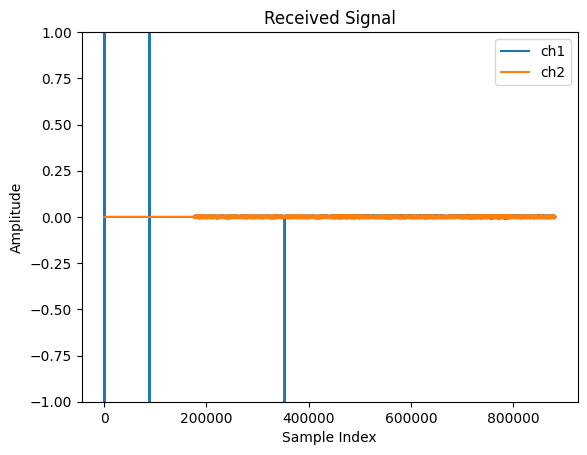

[ERROR] [UHD] An unexpected exception was caught in a task loop.The task loop will now exit, things may not work.EnvironmentError: IOError: usb rx8 transfer status: LIBUSB_TRANSFER_NO_DEVICE


In [7]:
plt.figure()
print("Saved")
plt.plot(list(datum[0] for datum in rx_buffer_list), label="ch1")
plt.plot(list(datum[0] for datum in rx_buffer_list_ch2), label="ch2") 
plt.title('Received Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.ylim([-1, 1])
plt.legend()
plt.show()

In [4]:
print(np.size(rx_buffer_list)/2)
print(np.size(rx_buffer_list_ch2)/2)

6614325.0
6614325.0
